In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt

device = torch.device("mps")

In [3]:
# simple tokenization by characters

lines = open('./input.txt', 'r').read()

vocab = list(set(lines))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))

vocab size: 65


In [4]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset

tensor([31, 21, 22,  ...,  8, 46, 54], dtype=torch.int8)

In [84]:
config = {
    "d_model": 100,
    "vocab_size": len(vocab),
    'batch_size': 32,
    'context_window': 10,
}


def get_batches(data, split, batch_size, context_window):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]
    
    batch_data = train
    if split == 'val':
        batch_data = val
    
    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[('I command ', ' command t'),
 ('s report.\n', ' report.\n\n'),
 ('pon you fo', 'on you for'),
 ('nt well. A', 't well. Al'),
 ("ry's frien", "y's friend"),
 ('for our Ir', 'or our Iri'),
 ('man that w', 'an that wr'),
 (' me,\nAnd w', 'me,\nAnd wo'),
 (" have, I'l", "have, I'll"),
 ('ason. They', 'son. They '),
 ('but now I ', 'ut now I a'),
 ('nd not a w', 'd not a wo'),
 ('hat have b', 'at have be'),
 ('now,\nWith ', 'ow,\nWith s'),
 ('she may lo', 'he may lon'),
 ('ood to be ', 'od to be y'),
 ('Of such as', 'f such as '),
 ('heir\ncause', 'eir\ncause '),
 ('\n\nDERBY:\nJ', '\nDERBY:\nJo'),
 (' succeedin', 'succeeding'),
 ('s since I ', ' since I s'),
 ('was urged ', 'as urged t'),
 ('oisted sai', 'isted sail'),
 ('ght.\n\nAll:', 'ht.\n\nAll:\n'),
 ('er for his', 'r for his '),
 ('heart,\nAnd', 'eart,\nAnd '),
 ('ies asleep', 'es asleep,'),
 ('not worth ', 'ot worth a'),
 (' have no c', 'have no ch'),
 (' remember ', 'remember m'),
 ('! which th', ' which the'),
 ('LLA:\nDoth ', '

In [85]:
class MaskedRotarySelfAttentionHead(nn.Module):
    """
    Rotary embeddings.

    Input: (BATCH_SIZE x CONTEXT_WINDOW)
    Output: (BATCH_SIZE x CONTEXT_WINDOW x EMBEDDING_DIM)
    """
    def __init__(self, config):
        super().__init__()
        self.config = config

        if config['d_model'] % 2 != 0:
            raise ValueError("d_model must be divisible by 2")
        self.w_q = torch.randn(config['d_model'], config['d_model'], requires_grad=True)
        self.w_k = torch.randn(config['d_model'], config['d_model'], requires_grad=True)
        self.w_v = torch.randn(config['d_model'], config['d_model'], requires_grad=True)
        self.register_buffer("tril", torch.tril(torch.ones(config['context_window'], config['context_window']))) # mask
        
    def get_rotary_matrix(self, x):
        b, m, d = x.shape
        R = torch.zeros((d, d, m))
        for position in range(m):
            for i in range(d//2):
                theta = 10000. ** (-2.*(i - 1) / d)
                m_theta = position * theta
                R[2*i,2*i, position] = np.cos(m_theta)
                R[2*i,2*i+1, position] = - np.sin(m_theta)
                R[2*i+1,2*i, position] = np.sin(m_theta)
                R[2*i+1,2*i+1, position] = np.cos(m_theta)
        return R

    def forward(self, x):
        """
        x: [BATCH_SIZE x CONTEXT_WINDOW x EMBEDDING_DIM]
        out: [BATCH_SIZE x CONTEXT_WINDOW x EMBEDDING_DIM]
        """
        b, m, d = x.shape
        R = self.get_rotary_matrix(x) # [d x d x m]

        q_rotated_query_weight = self.w_q @ R # [d x d x m]
        q = q_rotated_query_weight.view(m, d, d) @ x.view(m, d, b)
        q = q.view(b, m, d)

        k_rotated_query_weight = self.w_k @ R # [d x d x m]
        k = k_rotated_query_weight.view(m, d, d) @ x.view(m, d, b)
        k = k.view(b, m, d)
        
        B = (q @ k.transpose(1,2)) / np.sqrt(self.config['d_model'])
        mask = B.masked_fill(self.tril[:m, :m] == 0, float("-inf"))
        a = F.softmax(mask, dim=-1) # attention
        v = x @ self.w_v 
        out = a @ v
        return out


config = {
    "batch_size": 3,
    "context_window": 10,
    "d_model": 128,
}
r = MaskedRotarySelfAttentionHead(config)
batch = torch.randn((3, 10, config['d_model']))

r(batch).shape

torch.Size([3, 10, 128])

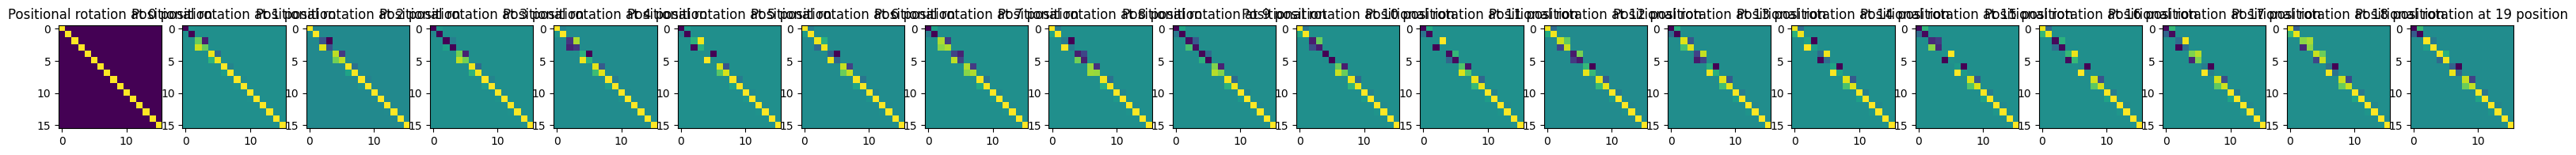

In [200]:
config = {
    "batch_size": 3,
    "context_window": 20,
    "d_model": 16,
}
r = MaskedRotarySelfAttentionHead(config)
batch = torch.randn((3, 20, config['d_model']))

R = r.get_rotary_matrix(batch)
fig, ax = plt.subplots(1, R.shape[-1], figsize=(R.shape[-1] * 2, 5))
for i in range(R.shape[-1]):
    ax[i].imshow(R[:, :, i].detach().numpy())
    ax[i].set_title(f'Positional rotation at {i} position')

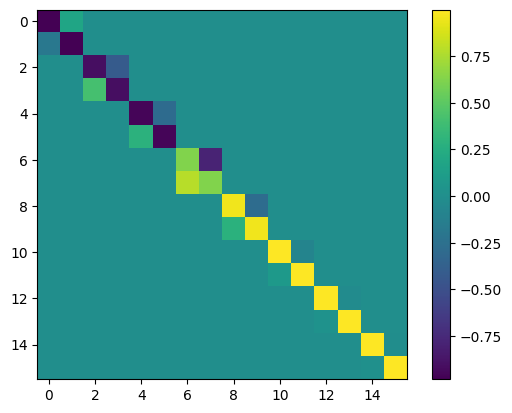

In [87]:
config = {
    "batch_size": 3,
    "context_window": 10,
    "d_model": 16,
}
r = MaskedRotarySelfAttentionHead(config)
batch = torch.randn((3, 10, config['d_model']))

R = r.get_rotary_matrix(batch)
plt.imshow(R[...,-1].detach().numpy())
plt.colorbar()

In [88]:
config = {
    "batch_size": 1,
    "context_window": 10,
    "d_model": 16,
}
r = MaskedRotarySelfAttentionHead(config)
batch = torch.randn((1, 10, config['d_model']))

R = r.get_rotary_matrix(batch)
b, m, d = batch.shape

q_rotated_query_weight = r.w_q @ R # [d x d x m]
q = q_rotated_query_weight.view(m, d, d) @ batch.view(m, d, b)
q = q.view(b, m, d)

k_rotated_query_weight = r.w_k @ R # [d x d x m]
k = k_rotated_query_weight.view(m, d, d) @ batch.view(m, d, b)
k = k.view(b, m, d)

B = (q @ k.transpose(1,2)) / np.sqrt(r.config['d_model'])
mask = B.masked_fill(r.tril[:m, :m] == 0, float("-inf"))
a = F.softmax(mask, dim=-1) # attention
v = batch @ r.w_v 
out = a @ v

In [89]:
class MaskedRotaryNultiHeadedAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            MaskedRotarySelfAttentionHead(config) for _ in range(config["n_heads"])
            nn.Attention(config["d_model"], config["d_model"], config["d_model"]) for _ in range(config["n_heads"])
        ])
        self.linear = nn.Linear(config["n_heads"] * config["d_model"], config["d_model"])
        self.dropout = nn.Dropout(0.1)


    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.dropout(self.linear(out))
        return out

config = {
    "n_heads": 8,
    "d_model": 128,
    "batch_size": 32,
    "context_window": 16,
}

batch = torch.randn((1, 1, config['d_model']))
m = MaskedRotaryNultiHeadedAttention(config)

m(batch).shape

torch.Size([1, 1, 128])

In [90]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(config['d_model'], config['d_model'])
        self.linear = nn.Linear(config['d_model'], config['d_model'])
        self.beta = torch.randn(1, requires_grad=True)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

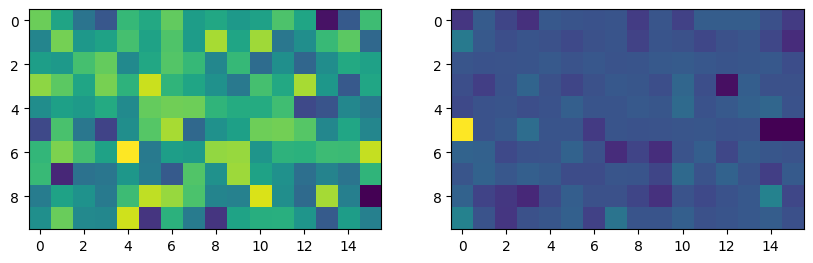

In [91]:
config = {
    "n_heads": 8,
    "d_model": 16,
    "batch_size": 3,
    "context_window": 10,
}
s = SwiGLU(config)
batch = torch.randn(config['batch_size'], config['context_window'], config["d_model"])
out = s(batch)
out.shape
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(batch[0].detach().numpy())
ax[1].imshow(out[0].detach().numpy())

In [92]:
class RMSNorm(nn.Module):
    def __init__(self, d, p=-1., eps=1e-8, bias=False):
        """
            Root Mean Square Layer Normalization
        :param d: model size
        :param p: partial RMSNorm, valid value [0, 1], default -1.0 (disabled)
        :param eps:  epsilon value, default 1e-8
        :param bias: whether use bias term for RMSNorm, disabled by
            default because RMSNorm doesn't enforce re-centering invariance.

        https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py
        """
        super(RMSNorm, self).__init__()

        self.eps = eps
        self.d = d
        self.p = p
        self.bias = bias

        self.scale = nn.Parameter(torch.ones(d))
        self.register_parameter("scale", self.scale)

        if self.bias:
            self.offset = nn.Parameter(torch.zeros(d))
            self.register_parameter("offset", self.offset)

    def forward(self, x):
        if self.p < 0. or self.p > 1.:
            norm_x = x.norm(2, dim=-1, keepdim=True)
            d_x = self.d
        else:
            partial_size = int(self.d * self.p)
            partial_x, _ = torch.split(x, [partial_size, self.d - partial_size], dim=-1)

            norm_x = partial_x.norm(2, dim=-1, keepdim=True)
            d_x = partial_size

        rms_x = norm_x * d_x ** (-1. / 2)
        x_normed = x / (rms_x + self.eps)

        if self.bias:
            return self.scale * x_normed + self.offset

        return self.scale * x_normed

In [192]:
config = {
    "n_heads": 8,
    "d_model": 512,
    "batch_size": 3,
    "context_window": 10,
}

class LlamaLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.prenorm = RMSNorm(config['d_model'])

        self.wq = nn.Linear(config['d_model'], config['d_model'])
        self.wk = nn.Linear(config['d_model'], config['d_model'])
        self.wv = nn.Linear(config['d_model'], config['d_model'])

        self.multihead = nn.MultiheadAttention(
            config['d_model'], config['n_heads'], batch_first=True
        )

        self.ffn = nn.Sequential(
            RMSNorm(config['d_model']),
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config),
        )

    def forward(self, x):
        b,m,d = x.shape
        prenorm = self.prenorm(x)
        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)

        def look_ahead_mask(tgt_len:int, src_len:int) -> torch.FloatTensor:  
            """ this will be applied before sigmoid function, so '-inf' for proper positions needed. 
            look-ahead masking is used for decoder in transformer, 
            which prevents future target label affecting past-step target labels. """
            mask = torch.triu(torch.ones(tgt_len, src_len), diagonal=1)
            mask[mask.bool()] = -float('inf')
            return mask

        output, weights = self.multihead(q, k, v, attn_mask=look_ahead_mask(m,m), is_causal=True)
        out = output + self.ffn(output)

        return out

m = LlamaLayer(config)
out = m(batch)

In [ ]:
from collections import OrderedDict

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.layers = nn.Sequential(OrderedDict([
            (f"llama_layer_{i}", LlamaLayer(config)) for i in range(config['n_layers'])
        ]))
        self.linear = nn.Linear(config['d_model'], config['vocab_size'])

        # debugging rotary attention
        self.position_embedding = nn.Embedding(config['context_window'], config['d_model'])

    def forward(self, idx, targets=None):
        """
        idx: [batch_size, seq_len]
        targets: [batch_size, seq_len]
        """
        b, m = idx.shape

        embeds = self.embedding(idx) + self.position_embedding(torch.arange(m)).unsqueeze(0) # [batch_size, seq_len, hidden_size]
        out = self.layers(embeds) # [batch_size, seq_len, d_model]
        logits = self.linear(out) # [batch_size, seq_len, vocab_size]
        logits = F.softmax(logits, dim=-1) # [batch_size, seq_len, vocab_size]

        if targets is None:
            return logits
        
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

    def generate(self, idx, max_len=20):
        """
        idx: [batch_size, seq_len]
        """
        for i in range(max_len):
            logits = self(idx[:, -self.config['context_window']:])
            pred = torch.argmax(logits, dim=-1)[..., -1:]
            idx = torch.cat([idx, pred], dim=-1)

        return idx

In [170]:
config = {
    "n_heads": 8,
    "d_model": 128,
    "batch_size": 32,
    "n_layers": 4,
    "context_window": 16,
    "vocab_size": len(vocab),
    "epochs": 1000,
    "log_interval": 10,
}

model = Llama(config)
total_params = sum([p.numel() for p in model.parameters()])
print(total_params)

xb, yb = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
logits, loss = model(xb, yb)
logits.shape

680257


torch.Size([32, 16, 65])

In [186]:
import time


@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

# train
optimizer = torch.optim.Adam(
    model.parameters(), 
    # betas=(.9, .95), 
    # weight_decay=.1, 
    # eps=1e-9, 
    lr=3e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 300, eta_min=1e-5)

start_time = time.time()
losses = []

for epoch in range(config['epochs']):
    optimizer.zero_grad()
    
    xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
    logits, loss = model(xs, targets=ys)
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    # scheduler.step()

    if epoch % config['log_interval'] == 0 and epoch > 0:
        batch_time = time.time() - start_time
        losses += [evaluate_loss()]
        print(f"Epoch {epoch} | Loss {loss.item():.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
        start_time = time.time()
    
        break

for name, param in model.named_parameters():
    # if the grad is being tracked, print the grad norm and param norm
    if param.grad is not None:
        print(f"{name} | grad zero {torch.sum(param.grad == 0).item()/param.grad.numel():.3f} | grad near zero {torch.sum(torch.abs(param.grad) < 1e-3).item()/param.grad.numel():.3f}")

Epoch 10 | Loss 4.170 | Time 0.459 | ETA in seconds 45.468
embedding.weight | grad zero 0.262 | grad near zero 1.000
layers.llama_layer_0.wq.weight | grad zero 0.000 | grad near zero 1.000
layers.llama_layer_0.wq.bias | grad zero 0.000 | grad near zero 1.000
layers.llama_layer_0.wk.weight | grad zero 0.000 | grad near zero 1.000
layers.llama_layer_0.wk.bias | grad zero 0.000 | grad near zero 1.000
layers.llama_layer_0.wv.weight | grad zero 0.000 | grad near zero 1.000
layers.llama_layer_0.wv.bias | grad zero 0.000 | grad near zero 1.000
layers.llama_layer_0.multihead.in_proj_weight | grad zero 0.000 | grad near zero 1.000
layers.llama_layer_0.multihead.in_proj_bias | grad zero 0.000 | grad near zero 1.000
layers.llama_layer_0.multihead.out_proj.weight | grad zero 0.000 | grad near zero 1.000
layers.llama_layer_0.multihead.out_proj.bias | grad zero 0.000 | grad near zero 1.000
layers.llama_layer_0.ffn.0.scale | grad zero 0.000 | grad near zero 1.000
layers.llama_layer_0.ffn.1.weight | g